# Import Necessary Modules

In [ ]:
import twint
import time
import json
import instaloader

import os
from os import path

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *

import datetime
# import emoji
import re

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 

# INSTAGRAM
# Installing InstaLoader & Authentication

In [ ]:
# !pip install instaloader

In [ ]:
# Create an instance of Instaloader class
loader = instaloader.Instaloader()

# Enter your Instagram handle and password
ACCOUNT = 'ilovesmt203'
PASSWORD = 'ilovesmt203!haha'

# Upon successful authentication, you should see a message saying Authentication OK.
# Otherwise, check your login details
try:
    loader.login(ACCOUNT, PASSWORD)
    print("Authentication OK")
except:
    print("Error during authentication")
    
# customise the parameter settings based on your download preference
# configuration 
loader = instaloader.Instaloader(download_pictures=False,
                            download_video_thumbnails=False,
                            download_videos=False,
                            download_comments=True,
                            download_geotags=True,
                            compress_json=False,
                            post_metadata_txt_pattern="")

# Downloading Posts as JSON files

In [ ]:
HASHTAG = "impeachtrump"

# Create a Hashtag instance from a given hashtag name
hashtag = instaloader.Hashtag.from_name(loader.context, HASHTAG)
loaded_posts = hashtag.get_all_posts()

for cnt_post, post in enumerate(loaded_posts):
    # date_created = datetime.datetime.fromtimestamp(post.date_utc)
    if datetime.datetime(2021,1,6) <= post.date_local <= datetime.datetime(2021,1, 15):
        try:
            loader.download_post(post, target='#'+hashtag.name)
            time.sleep(3)
        except:
            print("\nError in downloading. Process halted.")


# Writing Functions to Extract Information
## Function to extract Individual Post Information (JSON post files into a DataFrame)

In [4]:
def convert_json_posts_to_df(json_path):
    substring = "comment"
    json_files = [filename for filename in os.listdir(json_path) if (filename.endswith('.json') and substring not in filename)]
    post_list = []

    # iterate through the list of JSON files
    for js in json_files:
            
        # open and read each json file
        with open(os.path.join(json_path, js)) as json_file:
            json_text = json.load(json_file)
            #pprint.pprint(json.text)
            
            try:
                # extract Instagram post information
                comment_id = json_text['node']['id']
                user_id = json_text['node']['owner']['id']
                unix_timestamp = json_text['node']['taken_at_timestamp']
                date_time = datetime.datetime.fromtimestamp(unix_timestamp)
                likes_count = json_text['node']['edge_liked_by']['count']
                
                try:
                    comment_raw = json_text['node']['accessibility_caption']
                except:
                    pass
            except:
                pass
        
        post_list.append([comment_id, user_id, date_time, likes_count, comment_raw])
    df = pd.DataFrame(data=post_list, columns=['comment_id', 'user_id', 'date_time', 'likes_count', 'comment_raw'])
    return df

## Function to extract Comments from each Post (comment.JSON files into a DataFrame)

In [5]:
 def convert_comments_to_df(json_path):
    substring = "comment"
    json_files = [filename for filename in os.listdir(json_path) if (filename.endswith('.json') and substring in filename)]
    post_list = []

    # iterate through the list of JSON files
    for js in json_files:
            
        # open and read each json file
        with open(os.path.join(json_path, js)) as json_file:
            json_text = json.load(json_file)
            #pprint.pprint(json.text)
            
            #extract comments from comments.json files
            for comment in json_text:
                comment_id = comment['id']
                user_id = comment['owner']['id']
                date_time = datetime.datetime.fromtimestamp(comment['created_at'])
                likes_count = comment['likes_count']
                comment_raw = comment['text']
                
                post_list.append([comment_id, user_id, date_time, likes_count, comment_raw])

    df = pd.DataFrame(data=post_list, columns=['comment_id', 'user_id', 'date_time', 'likes_count', 'comment_raw'])
    return df

# Extracting Information from Downloaded Files
## #impeachtrump

In [6]:
mypath = "."
folder_name = '#impeachtrump'

json_path1 = f'{mypath}/{folder_name}'
json_path1

'./#impeachtrump'

In [15]:
# pd.set_option('display.max_colwidth', -1)
# pd.set_option('display.max_rows', None)

df1 = convert_json_posts_to_df(json_path1)
df1.insert(2, 'platform', 'instagram')
# df1.info()

df2 = convert_comments_to_df(json_path1)
df2.insert(2, 'platform', 'instagram')
df2.head()

,comment_id,user_id,platform,date_time,likes_count,comment_raw
0,17985862963333577,7947840139,instagram,2021-02-15 02:25:52,1,Trump is based stfu
1,17903656549677337,44932096155,instagram,2021-01-19 04:52:37,2,I love your work 💯
2,17887117012943012,44932096155,instagram,2021-01-18 01:34:26,1,I survived as well.We got thru it tho. Others ...
3,17993289781311660,27864408893,instagram,2021-01-14 17:32:17,0,No No No
4,17858276657342010,32878502,instagram,2021-01-12 04:07:06,0,What about the day that David dorn was murdered?


In [14]:
frames = [df1, df2]
combined1 = pd.concat(frames) #combining both posts and comments in the same dataframe
combined1.dropna(inplace=True)
combined1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5779 entries, 0 to 4094
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   comment_id   5779 non-null   object        
 1   user_id      5779 non-null   object        
 2   platform     5779 non-null   object        
 3   date_time    5779 non-null   datetime64[ns]
 4   likes_count  5779 non-null   int64         
 5   comment_raw  5779 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 316.0+ KB


In [27]:
combined1 = combined1[combined1['comment_raw'].str.startswith("Photo by")==False]
combined1 = combined1[combined1['comment_raw'].str.startswith("Photo shared by")==False]
combined1.head()

# combined1.to_csv('impeach_trump_comments.csv')

,comment_id,user_id,platform,date_time,likes_count,comment_raw
82,2497473678235403715,44928907276,instagram,2021-01-30 01:41:24,23,News today update facts of the day
209,2498969812124817063,44928907276,instagram,2021-02-01 03:13:57,22,News today facts of the day summary
279,2499676630782217488,44928907276,instagram,2021-02-02 02:38:16,19,News us today
560,2502521874464821989,44928907276,instagram,2021-02-06 00:51:16,25,News today facts of the day summary
876,2505381274410547229,44172838713,instagram,2021-02-09 23:32:23,6,Impeach and Convict Donald Trump Lapel Pins fr...


## #trumpimpeachment

In [16]:
mypath = "."
folder_name = '#trumpimpeachment'

json_path2 = f'{mypath}/{folder_name}'
json_path2

'./#trumpimpeachment'

In [17]:
df3 = convert_json_posts_to_df(json_path2)
df3.insert(2, 'platform', 'instagram')
# df1.head()

df4 = convert_comments_to_df(json_path2)
df4.insert(2, 'platform', 'instagram')
df4.head()

,comment_id,user_id,platform,date_time,likes_count,comment_raw
0,17966998288364376,33597388,instagram,2021-02-13 22:54:15,0,Yeah all the black people attacking and murder...
1,17885746028017595,2299592476,instagram,2021-02-13 09:13:03,0,Are you referring to what is happening on the ...
2,17842696493521935,1651100777,instagram,2021-01-22 12:51:37,0,🙌
3,18138103390087013,4147796433,instagram,2021-01-21 06:42:10,1,@debbyanmcfarlane
4,17914123522572768,41693285374,instagram,2021-01-19 20:39:03,0,"I have a proposal for you, talk me to privatel..."


In [18]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2551 entries, 0 to 2550
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   comment_id   2551 non-null   int64         
 1   user_id      2551 non-null   object        
 2   platform     2551 non-null   object        
 3   date_time    2551 non-null   datetime64[ns]
 4   likes_count  2551 non-null   int64         
 5   comment_raw  2551 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 119.7+ KB


In [20]:
frames = [df3, df4]
combined2 = pd.concat(frames)
combined2.dropna(inplace=True)
combined2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4061 entries, 1 to 2550
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   comment_id   4061 non-null   object        
 1   user_id      4061 non-null   object        
 2   platform     4061 non-null   object        
 3   date_time    4061 non-null   datetime64[ns]
 4   likes_count  4061 non-null   int64         
 5   comment_raw  4061 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 222.1+ KB


In [26]:
combined2 = combined2[combined2['comment_raw'].str.startswith("Photo by")==False]
combined2 = combined2[combined2['comment_raw'].str.startswith("Photo shared by")==False]
combined2.head()

combined2.to_csv('trump_impeachment_comments.csv')

,comment_id,user_id,platform,date_time,likes_count,comment_raw
18,2481702515306198095,4028120102,instagram,2021-01-08 07:26:55,2432,These recent events are just a reminder of how...
471,2486531771729841659,8603230290,instagram,2021-01-14 23:21:47,85,Trump has been impeached a second time so the ...
679,2489359159854901418,44955229694,instagram,2021-01-18 20:59:18,2,Gandhi quote
782,2493153046588846267,44928907276,instagram,2021-01-24 02:37:05,28,News today summary every topic larry king
1184,2505615380920420667,259090671,instagram,2021-02-10 07:17:31,4417,Top stories. Some returned travellers who quar...


## Merging DataFrames from both hashtags

In [33]:
frames = [combined1, combined2]
combined = pd.concat(frames)
combined.info()

combined.to_csv('combined_instagram_comments.csv')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6660 entries, 82 to 2550
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   comment_id   6660 non-null   object        
 1   user_id      6660 non-null   object        
 2   platform     6660 non-null   object        
 3   date_time    6660 non-null   datetime64[ns]
 4   likes_count  6660 non-null   int64         
 5   comment_raw  6660 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 364.2+ KB


In [34]:
combined.head()

,comment_id,user_id,platform,date_time,likes_count,comment_raw
82,2497473678235403715,44928907276,instagram,2021-01-30 01:41:24,23,News today update facts of the day
209,2498969812124817063,44928907276,instagram,2021-02-01 03:13:57,22,News today facts of the day summary
279,2499676630782217488,44928907276,instagram,2021-02-02 02:38:16,19,News us today
560,2502521874464821989,44928907276,instagram,2021-02-06 00:51:16,25,News today facts of the day summary
876,2505381274410547229,44172838713,instagram,2021-02-09 23:32:23,6,Impeach and Convict Donald Trump Lapel Pins fr...


# Conduct Text Preprocessing on 'comment_raw' column

In [39]:
# initialise lists for later
comment_cleaned_emoji_list = []
comment_cleaned_no_emoji_list = []
comment_processed = []

# prepare stopwords list
stopwords_list = stopwords.words('english')
stopwords_list += ['donald','trump', 'impeachment', 'february', 'one', 'get', 'would', 'news'] # additional stopwords customised based on context 

# iterate through every comment in the dataframe
for text in combined['comment_raw']: 
    text = re.sub(r"(?:\@|\#|https?\://)\S+", "", str(text)) # remove hashtag mentions and urls
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE) 
    text_no_emoji = emoji_pattern.sub(r'', str(text)) # remove emojis
    text_tokenised = word_tokenize(text) # tokenise words
    text_lower = [w.lower() for w in text_tokenised] # change to lowercase
    text_words_only = [w for w in text_lower if re.search('^[a-z]+$',w)] # keep only english words
    text_stopremoved = [w for w in text_words_only if w not in stopwords_list] # remove stopwords

    # stemmer = PorterStemmer()
    # text_stemmed = [stemmer.stem(w) for w in text_stopremoved]
    # output.append(text_stemmed)

    # append necessary items to lists
    comment_cleaned_emoji_list.append(text)
    comment_cleaned_no_emoji_list.append(text_no_emoji)
    comment_processed.append(text_stopremoved)

#Create new columns
combined['comment_cleaned_emoji'] = comment_cleaned_emoji_list # to be used for vader analysis (no stopwords removed, but with emojis)
combined['comment_cleaned_no_emoji'] = comment_cleaned_no_emoji_list # to be used for vader analysis (no stopwords removed, but with emojis)
combined['comment_processed'] = comment_processed # to be used for wordcloud (stopwords removed)

combined.head()

,comment_id,user_id,platform,date_time,likes_count,comment_raw,comment_cleaned_emoji,comment_cleaned_no_emoji,comment_processed
82,2497473678235403715,44928907276,instagram,2021-01-30 01:41:24,23,News today update facts of the day,News today update facts of the day,News today update facts of the day,"[today, update, facts, day]"
209,2498969812124817063,44928907276,instagram,2021-02-01 03:13:57,22,News today facts of the day summary,News today facts of the day summary,News today facts of the day summary,"[today, facts, day, summary]"
279,2499676630782217488,44928907276,instagram,2021-02-02 02:38:16,19,News us today,News us today,News us today,"[us, today]"
560,2502521874464821989,44928907276,instagram,2021-02-06 00:51:16,25,News today facts of the day summary,News today facts of the day summary,News today facts of the day summary,"[today, facts, day, summary]"
876,2505381274410547229,44172838713,instagram,2021-02-09 23:32:23,6,Impeach and Convict Donald Trump Lapel Pins fr...,Impeach and Convict Donald Trump Lapel Pins fr...,Impeach and Convict Donald Trump Lapel Pins fr...,"[impeach, convict, lapel, pins, santa, teresa,..."


# Creating Word Clouds
## Basic WordCloud

In [40]:
# create list of words
wordcloud_words = []
for wordlist in combined['comment_processed']:
    for word in wordlist:
        wordcloud_words.append(str(word))

# create string of all words
wordcloud_string = ""
for word in wordcloud_words:
    wordcloud_string += word+" "

wordcloud_string[:500]

'today update facts day today facts day summary us today today facts day summary impeach convict lapel pins santa teresa studios update facts day summary quiz quizzes updated every day every topic feb today facts day summary quiz quizzes every day every topic based stfu love work survived got thru tho others voting others got mistake office day david dorn murdered think misprinted shit lol love taste tears morning two weeks til political party respect rules democracy state right take steps includ'

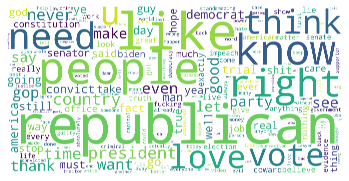

In [41]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stopwords_list, background_color="white", width=10000, height=5000).generate(wordcloud_string)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file("impeachtrump.png")

## With Background Shape

In [42]:
mask = np.array(Image.open("ig_logo.jpg"))
#photos that have values all zero are not recommended
mask

array([[[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [238, 238, 238],
        [238, 238, 238],
        [238, 238, 238]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [238, 238, 238],
        [238, 238, 238],
        [238, 238, 238]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [238, 238, 238],
        [238, 238, 238],
        [238, 238, 238]],

       ...,

       [[238, 238, 238],
        [238, 238, 238],
        [238, 238, 238],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[238, 238, 238],
        [238, 238, 238],
        [238, 238, 238],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[238, 238, 238],
        [238, 238, 238],
        [238, 238, 238],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]]

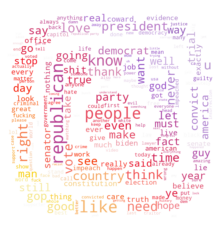

In [43]:
# Generate wordcloud
#method 1 (uses colormap)
image_colors = ImageColorGenerator(mask)
cloud = WordCloud(background_color='white', stopwords = stopwords_list, mask=mask, color_func = image_colors).generate(wordcloud_string)
# Plot
# plt.figure(figsize=[7,7])
plt.imshow(cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

#saving the wordcloud
cloud.to_file('instagram_logo_wordcloud.png')

# Vader Sentiment Analysis

In [44]:
def vader_compound_score(sentence): 
    sid_obj = SentimentIntensityAnalyzer()
    sentiment_dict = sid_obj.polarity_scores(sentence) 
    return sentiment_dict['compound']

combined['vader_compound_emoji'] = combined['comment_cleaned_emoji'].apply(vader_compound_score) 
combined['vader_compound_no_emoji'] = combined['comment_cleaned_no_emoji'].apply(vader_compound_score) 
combined

,comment_id,user_id,platform,date_time,likes_count,comment_raw,comment_cleaned_emoji,comment_cleaned_no_emoji,comment_processed,vader_compound_emoji,vader_compound_no_emoji
82,2497473678235403715,44928907276,instagram,2021-01-30 01:41:24,23,News today update facts of the day,News today update facts of the day,News today update facts of the day,"[today, update, facts, day]",0.0000,0.0000
209,2498969812124817063,44928907276,instagram,2021-02-01 03:13:57,22,News today facts of the day summary,News today facts of the day summary,News today facts of the day summary,"[today, facts, day, summary]",0.0000,0.0000
279,2499676630782217488,44928907276,instagram,2021-02-02 02:38:16,19,News us today,News us today,News us today,"[us, today]",0.0000,0.0000
560,2502521874464821989,44928907276,instagram,2021-02-06 00:51:16,25,News today facts of the day summary,News today facts of the day summary,News today facts of the day summary,"[today, facts, day, summary]",0.0000,0.0000
876,2505381274410547229,44172838713,instagram,2021-02-09 23:32:23,6,Impeach and Convict Donald Trump Lapel Pins fr...,Impeach and Convict Donald Trump Lapel Pins fr...,Impeach and Convict Donald Trump Lapel Pins fr...,"[impeach, convict, lapel, pins, santa, teresa,...",0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...
2546,17905066348680687,1088318186,instagram,2021-02-17 09:49:06,0,"No es necesario tirarla, el conocimiento es poder","No es necesario tirarla, el conocimiento es poder","No es necesario tirarla, el conocimiento es poder","[es, necesario, tirarla, el, conocimiento, es,...",-0.2960,-0.2960
2547,17933472688479027,415888562,instagram,2021-02-17 23:34:31,0,https://pace.coe.int/en/files/29004/html Aquí...,Aquí tenéis el enlace a reglamento europeo N...,Aquí tenéis el enlace a reglamento europeo N...,"[el, enlace, reglamento, europeo, nadie, puede...",0.0000,0.0000
2548,17874465812235413,36009065603,instagram,2021-02-17 08:32:43,0,Eso! Genial opción solicitar compromiso escrit...,Eso! Genial opción solicitar compromiso escrit...,Eso! Genial opción solicitar compromiso escrit...,"[eso, genial, solicitar, compromiso, escrito, ...",0.4753,0.4753
2549,17874487577200028,2923605387,instagram,2021-02-17 06:34:37,0,Entonces?? Q vale decir o hacer?😢,Entonces?? Q vale decir o hacer?😢,Entonces?? Q vale decir o hacer?,"[entonces, q, vale, decir, hacer]",-0.5632,0.0000


In [45]:
combined.to_csv('instagram_comments_processed.csv')

(array([ 314.,  436.,  529.,  337., 2559.,  179.,  367.,  798.,  574.,
         567.]),
 array([-0.9946 , -0.79516, -0.59572, -0.39628, -0.19684,  0.0026 ,
         0.20204,  0.40148,  0.60092,  0.80036,  0.9998 ]),
 <BarContainer object of 10 artists>)

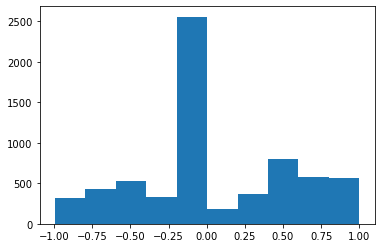

In [46]:
plt.hist(combined.vader_compound_emoji)

# TWITTER
# Scrape data from Twitter using Twint

In [ ]:
# Import packages
import twint
import time
import json

# Set up configurations
c = twint.Config()    
c.Store_csv = True # Store to json
c.Since = "2021-01-06 00:00:00" # Set start date for collection
c.Until = "2021-02-17 00:00:00" # Set end date for collection
c.Retweets = True # Include retweets done by user
c.Lang = "en" # Set language
c.Limit = 100000 # Set tweet limit to 100k 
# c.Near = "Singapore" # Set geograpic location 
c.Search = "trump impeachment" # Set search term
c.Output = "../Data/trump_impeachment_all_counties.csv" # Save output in current directory containing python script

# Run
twint.run.Search(c)

# Prepare basic dataframe for further processing

In [ ]:
# read raw csv file
df5 = pd.read_csv('../Data/trump_impeachment_all_counties.csv')

# combine 'date' and 'time' column into one column
df5['date_time'] = df5[['date', 'time']].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

# drop records with tweets that are non-english
df5 = df5.drop(df[df.language != 'en'].index)

# drop unnecessary columns
df5.drop(['quote_url', 'thumbnail', 'geo', 'source', 'user_rt_id', 'user_rt', 'retweet_id', 'retweet_date', 'translate', 'trans_src', 'trans_dest', 'cashtags', 'timezone', 'created_at', 'retweet', 'near', 'urls', 'photos', 'replies_count', 'retweets_count', 'link', 'video', 'reply_to', 'place', 'conversation_id', 'name', 'username', 'mentions', 'hashtags', 'language', 'date', 'time'], axis='columns', inplace=True)

# rename 'tweet' column to 'comment' to standardise column names
df5.rename(columns={'tweet':'comment_raw', 'id':'comment_id'}, inplace=True)

# insert 'platform' column, and label it 'twitter'
df5.insert(2, 'platform', 'twitter')

# rearrange columns to standardise with Instagram data
cols = list(df.columns)
cols = cols[:3] + [cols[5]] + [cols[4]] + [cols[3]]
df5 = df[cols]
df5


In [ ]:
df5.info()

# Conduct text preprocessing on 'comment_raw' column
Same code used for preprocessing previously for Instagram data

In [ ]:
# initialise lists for later
comment_cleaned_emoji_list = []
comment_cleaned_no_emoji_list = []
comment_processed_list = []

# prepare stopwords list
stopwords_list = stopwords.words('english')
stopwords_list += ['donald', 'trump', 'impeachment', 'amp', 'live', 'update', 'via'] #additional stopwords customised based on context

# iterate through every comment in the dataframe
for text in df5['comment_raw']:
    text = re.sub(r"(?:\@|\#|https?\://)\S+", "", text) # remove hashtag mentions and urls
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE) 
    text_no_emoji = emoji_pattern.sub(r'', text) # remove emojis
    text_tokenised = word_tokenize(text_no_emoji) # tokenise words
    text_lower = [w.lower() for w in text_tokenised] # change to lowercase
    text_words_only = [w for w in text_lower if re.search('^[a-z]+$',w)] # keep only english words
    text_stopremoved = [w for w in text_words_only if w not in stopwords_list] # remove stopwords

    # stemmer = PorterStemmer()
    # text_stemmed = [stemmer.stem(w) for w in text_stopremoved]
    # output.append(text_stemmed)

    # append necessary items to lists
    comment_cleaned_emoji_list.append(text)
    comment_cleaned_no_emoji_list.append(text_no_emoji)
    comment_processed_list.append(text_stopremoved)

# create new columns
df5['comment_cleaned_emoji'] = comment_cleaned_emoji_list # to be used to vader
df5['comment_cleaned_no_emoji'] = comment_cleaned_no_emoji_list # to be used for vader
df5['comment_processed'] = comment_processed_list # to be used for wordcloud
df6 = df6
df6.head()

# Creating WordClouds
## Basic WordCloud

In [ ]:
# create list of words
wordcloud_words = []
for wordlist in df6['comment_processed']:
    for word in wordlist:
        wordcloud_words.append(word)

# create string of all words
wordcloud_string = ""
for word in wordcloud_words:
    wordcloud_string += word+" "

wordcloud_string[:500]

In [ ]:
# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=STOPWORDS, background_color="white", width=10000, height=5000).generate(wordcloud_string)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file("trump_impeachment_no_stopwords.png")

## With background shape

In [ ]:
mask = np.array(Image.open("bird2.jpg"))
mask

In [ ]:
# Create custom matplotlib colourbar for better visuals for twitter

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=-1):
    if n == -1:
        n = cmap.N
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
         'trunc({name},{a:.2f},{b:.2f})'.format(name=cmap.name, a=minval, b=maxval),
         cmap(np.linspace(minval, maxval, n)))
    return new_cmap

# removes white and green edges in 'ocean' colourbar so that words can be seen
minColor = 0.28
maxColor = 0.75
ocean_t = truncate_colormap(plt.get_cmap("ocean"), minColor, maxColor)

fig = plt.figure()
ax = fig.add_axes([0,0, 1, 0.2])

cb = mpl.colorbar.ColorbarBase(ax, orientation='horizontal', 
                               cmap=ocean_t)

In [ ]:
# Generate wordcloud using colourmap created earlier
image_colors = ImageColorGenerator(mask)
cloud = WordCloud(background_color='white', stopwords = STOPWORDS, mask=mask, colormap=ocean_t).generate(wordcloud_string)
plt.imshow(cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

#saving the wordcloud
cloud.to_file('twitter_logo_wordcloud.png')

# Vader Sentiment Analysis

In [ ]:
df6['vader_compound_emoji'] = df6['comment_cleaned_emoji'].apply(vader_compound_score) 

In [ ]:
df6['vader_compound_no_emoji'] = df6['comment_cleaned_no_emoji'].apply(vader_compound_score) 

In [ ]:
df6.head()

In [ ]:
df6.to_csv("trump_impeachment_all_countries_processed.csv")

In [ ]:
plt.hist(df6.vader_score)

# VISUALISATION ANALYSIS

In [47]:
# Prepare dictionary for later
value_dict = {
    'twitter_positive':0,
    'twitter_neutral':0,
    'twitter_negative':0,
    'instagram_positive':0,
    'instagram_neutral':0,
    'instagram_negative':0,
}

# Read Twitter sentiment values

In [ ]:
df = pd.read_csv('trump_impeachment_all_countries_processed.csv')
df.head()

In [ ]:
for value in df['vader_compound_emoji']:
    if value >= 0.05: 
        value_dict['twitter_positive'] += 1
    elif value <= -0.05: 
        value_dict['twitter_negative'] += 1
    else: 
        value_dict['twitter_neutral'] += 1
print(value_dict)

# Read Instagram sentiment values

In [52]:
df2 = pd.read_csv('instagram_comments_processed.csv')
df2.head()

FileNotFoundError: [Errno 2] No such file or directory: 'instagram_comments_processed.csv'

In [ ]:
for value in df2['vader_compound_emoji']:
    if value >= 0.05: 
        value_dict['instagram_positive'] += 1
    elif value <= -0.05: 
        value_dict['instagram_negative'] += 1
    else: 
        value_dict['instagram_neutral'] += 1
print(value_dict)

# Create bar graph

In [ ]:
# Twitter
plt.bar(range(3), [value_dict['twitter_positive'], value_dict['twitter_neutral'], value_dict['twitter_negative']])
plt.xticks(range(3), ['twitter_positive', 'twitter_neutral', 'twitter_negative'])
plt.title("Number of comments per sentiment (Twitter)", fontsize = 18, pad=10)
plt.xlabel("Sentiment", fontsize = 12)
plt.ylabel("Number of comments",fontsize = 12)
num_comments_list = list(value_dict.values())
for i in range(3):
    plt.text(x=i-0.11 , y = num_comments_list[i]+3400 , s=f"{num_comments_list[i]}" , fontdict=dict(fontsize=8))

# plt.savefig('Number of comments per sentiment (Twitter).png')
plt.tight_layout()
plt.show()

In [ ]:
# Instagram
plt.bar(range(3), [value_dict['instagram_positive'], value_dict['instagram_neutral'], value_dict['instagram_negative']])
plt.xticks(range(3), ['instagram_positive', 'instagram_neutral', 'instagram_negative'])
plt.title("Number of comments per sentiment (Instagram)", fontsize = 18, pad=10)
plt.xlabel("Sentiment", fontsize = 12)
plt.ylabel("Number of comments",fontsize = 12)
# plt.savefig('Number of comments per sentiment (Twitter).png')
plt.tight_layout()
plt.show()